In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from keras.layers import Dense , LSTM , Dropout , Bidirectional
from keras.models import Sequential
from datetime import datetime
from numpy import sqrt
import joblib
import warnings

# Load the dataset (assuming it's a CSV file)
df = pd.read_csv("C:/Users/annbl/Downloads/Bitcoin Price Predictions/coin_Ethereum.csv")

# Ensure there are no missing values
df = df.dropna()

In [2]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)

new_df=df.drop(['SNo', 'Symbol', 'Name'], axis=1)
new_df.head()

,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2015-08-08,2.798810,0.714725,2.793760,0.753325,674188.0,4.548689e+07
2015-08-09,0.879810,0.629191,0.706136,0.701897,532170.0,4.239957e+07
2015-08-10,0.729854,0.636546,0.713989,0.708448,405283.0,4.281836e+07
2015-08-11,1.131410,0.663235,0.708087,1.067860,1463100.0,6.456929e+07
2015-08-12,1.289940,0.883608,1.058750,1.217440,2150620.0,7.364501e+07


In [3]:
values = df['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(np.mean(values))
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

383.91068
1512 648


In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1511
647


In [5]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(Bidirectional(LSTM(32)))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 1))
model.build(input_shape= (trainX.shape[0], trainX.shape[1], trainX.shape[2]))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (1511, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1511, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1511, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1511, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1511, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1511, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,345 (99.00 KB)

 Trainable params: 25,345 (99.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def train_model(model, loss, optimizer, trainX, trainY):

  model.compile(loss=loss, optimizer=optimizer)
  #train model
  history = model.fit(trainX, trainY, epochs=30, batch_size= 200,  validation_data = (testX, testY))
  # plot cost
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

def evaluate_model(model, testX, testY):

  yhat = model.predict(testX)
  plt.title('Curve of actual value and predicted value on the scale used in training')
  plt.plot(yhat, label='predict')
  plt.plot(testY, label='true')
  plt.legend()
  plt.show()

  yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  mse = mean_squared_error(testY_inverse, yhat_inverse)
  r2 = r2_score(testY_inverse, yhat_inverse)
  mae = mean_absolute_error(testY_inverse, yhat_inverse)
  evs = explained_variance_score(testY_inverse, yhat_inverse)
  rmse= sqrt(mse)

  print("Model: LSTM")
  print("Mean Squared Error:", mse)
  print("R-squared:", r2)
  print("Mean Absolute Error:", mae)
  print("Explained Variance Score:", evs)
  print("RMSE:", rmse)

  plt.title('Actual value curve and predicted value in US dollars')
  plt.plot(yhat_inverse, label='predict')
  plt.plot(testY_inverse, label='actual', alpha=0.5)
  plt.legend()
  plt.show()

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0044 - val_loss: 0.0436
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0364
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0185
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7554e-04 - val_loss: 0.0064
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2626e-04 - val_loss: 0.0016
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8275e-04 - val_loss: 9.9501e-04
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5214e-04 - val_loss: 0.0015
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3184e-04 - val_loss: 0.0017
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9476e-04 - val_loss: 0.0013
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1686e-04 - val_loss: 0.0017
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9267e-04 - val_loss: 0.0017
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.

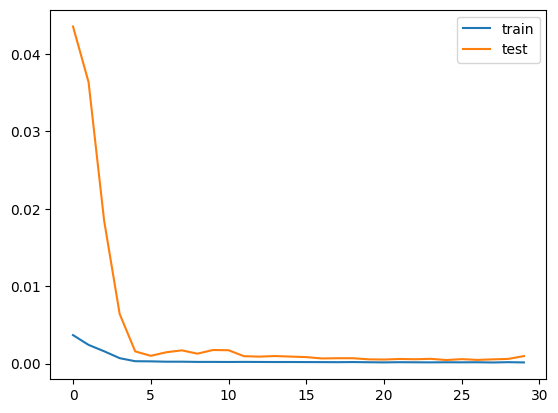

In [7]:
train_model(model, 'mse', 'adam', trainX, trainY)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


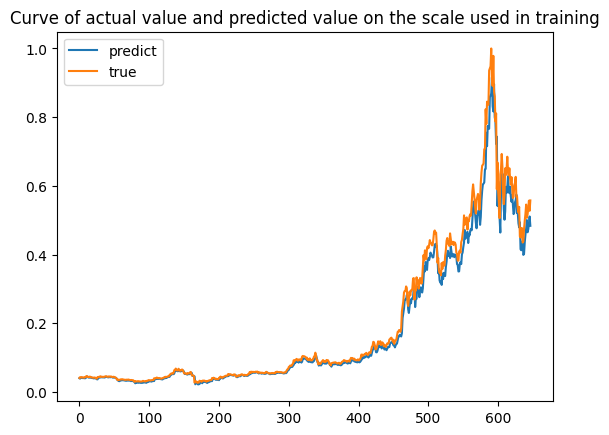

Model: LSTM
Mean Squared Error: 16685.559
R-squared: 0.9795058090602866
Mean Absolute Error: 69.53266
Explained Variance Score: 0.9845359921455383
RMSE: 129.17259


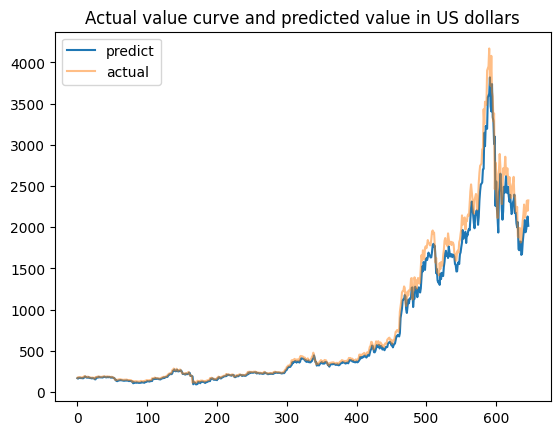

In [8]:
evaluate_model(model, testX, testY)

In [9]:
model.save("model_ETH.h5")

joblib.dump(scaler, 'scaler_eth.pkl')

['scaler_eth.pkl']

In [10]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def baseline(history):
  return np.mean(history)

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def predict_next_day(model, testX, testY):

  yhat_inverse = scaler.inverse_transform(model.predict(testX).reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  show_plot([testY_inverse[0:200], yhat_inverse[201],baseline(testY_inverse[201])], 1, 'Next day prediction')

  print('predicted value of day 201: ', yhat_inverse[201])
  print('Actual value of day 201: ', testY_inverse[201])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predicted value of day 201:  [164.38338]
Actual value of day 201:  [171.63858]


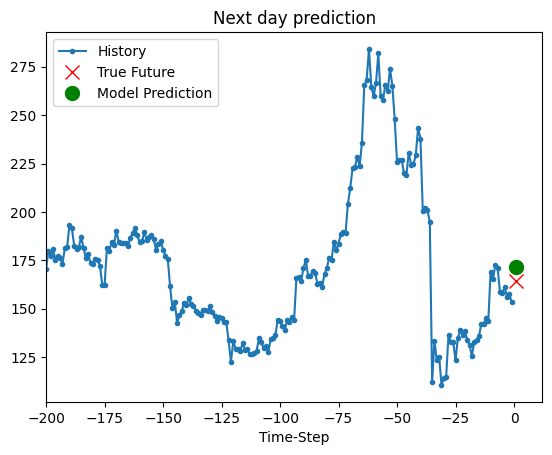

In [11]:
predict_next_day(model, testX, testY)

In [ ]:
def predict_price(model, scaler, user_input):
    try:
        # Reshape and scale the input
        user_input_reshaped = user_input.reshape(-1, 1)
        user_input_scaled = scaler.transform(user_input_reshaped).reshape(1, -1, 1)

        # Predict
        prediction = model.predict(user_input_scaled)
        prediction_reshaped = np.repeat(prediction, user_input_scaled.shape[1]).reshape(1, -1)

        # Inverse transform
        prediction_inverse = scaler.inverse_transform(
            np.concatenate((user_input_scaled.reshape(1, -1), prediction_reshaped), axis=0)
        )[1]

        return prediction_inverse[1]
    except Exception as e:
        print("Error during prediction:", e)
        return None

print("ETH Price Prediction System")
print("---------------------------")
high = float(input("Enter the highest price: "))
low = float(input("Enter the lowest price: "))
open = float(input("Enter the open price: "))
close = float(input("Enter the close price: "))
volume = float(input("Enter the volume: "))
user_input = np.array([[high,low,open,close,volume]])
predicted_value = predict_price(model, scaler, user_input)
print('Predicted Weighted Price:', predicted_value)

ETH Price Prediction System
---------------------------
Enter the highest price: 1.458962
Enter the lowest price: 0.258654
Enter the open price: 4.2563
Enter the close price: 2.3598
Enter the volume: 48556.25
1/1 [==============================] - 0s 27ms/step
Predicted Weighted Price: 11360.535640675016
